In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder 

In [2]:
section_list = ['151507', '151508', '151509', '151510', '151669', '151670', '151671', '151672', '151673', '151674', '151675', '151676']
section_id = section_list[0]

# 读取section_id这个slice的数据
adata = sc.read_visium(path=os.path.join('..', 'dataset', 'DLPFC', section_id))
adata.var_names_make_unique()

# 为数据添加ground truth
Ann_df = pd.read_csv(os.path.join('..', 'dataset', 'DLPFC', section_id, 'ground_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Cluster'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
adata

/home/ubuntu/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Cluster'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
pre_processed_adata = adata[:, adata.var['highly_variable']]

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


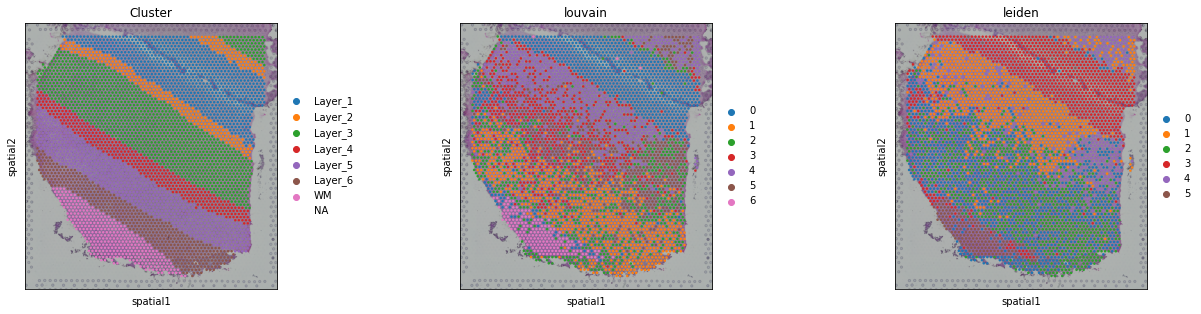

In [4]:
sc.pp.neighbors(pre_processed_adata)
sc.tl.louvain(pre_processed_adata)
sc.tl.leiden(pre_processed_adata)
adata.obs['louvain'] = pre_processed_adata.obs['louvain']
adata.obs['leiden'] = pre_processed_adata.obs['leiden']
sc.pl.spatial(adata, color=['Cluster', 'louvain', 'leiden'])

In [5]:
label = LabelEncoder().fit_transform(adata.obs['Cluster'])
pred_louvain = LabelEncoder().fit_transform(adata.obs['louvain'])
pred_leiden = LabelEncoder().fit_transform(adata.obs['leiden'])
print('louvain:', metrics.adjusted_rand_score(label, pred_louvain))
print('leiden:', metrics.adjusted_rand_score(label, pred_leiden))

louvain: 0.32244872392814783
leiden: 0.3212019698467249


In [6]:
# 建立一个独热编码的特征矩阵
one_hot = np.zeros((4226, 33538))
one_hot += np.eye(4226, 33538)
one_hot_adata = adata.copy()
one_hot_adata.X = one_hot
one_hot_adata

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Cluster', 'louvain', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'Cluster_colors', 'louvain_colors', 'leiden_colors'
    obsm: 'spatial'

         Falling back to preprocessing with `sc.pp.pca` and default params.


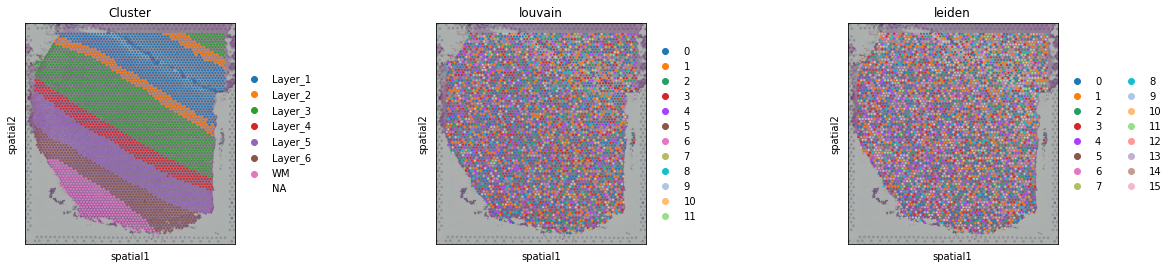

In [7]:
sc.pp.neighbors(one_hot_adata)
sc.tl.louvain(one_hot_adata)
sc.tl.leiden(one_hot_adata)
sc.pl.spatial(one_hot_adata, color=['Cluster', 'louvain', 'leiden'])